<a href="https://colab.research.google.com/github/Goof1999/Design-Optimization/blob/main/Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: Gradient-based Algorithms and Differentiable Programming


## 1. Introduction
Consider a simple formulation of rocket landing where the rocket state $x(t)$ is represented by its distance to the ground $d(t)$ and its velocity $v(t)$, i.e., $x(t) = [d(t), v(t)]^T$, where $t$ specifies time. The control input of the rocket is its acceleration $a(t)$. The discrete-time dynamics follows 

$$
\begin{aligned}
d(t+1) = d(t) + v(t) \Delta t, \\
v(t+1) = v(t) + a(t) \Delta t,
\end{aligned}
$$

where $\Delta t$ is a time interval. Further, let the closed-loop controller be 

$$
a(t) = f_{\theta}(x(t))
$$

where $f_{\theta}(\cdot)$ is a neural network with parameters $\theta$, which are to be determined through optimization.

For each time step, we assign a loss as a function of the control input and the state: $l(x(t),a(t))$. In this example, we will simply set $l(x(t),a(t))=0$ for all $t=1,...,T-1$, where $T$ is the final time step, and $l(x(T),a(T)) = ||x(T)||^2 = d(T)^2 + v(T)^2$. This loss encourages the rocket to reach $d(T)=0$ and $v(T)=0$, which are proper landing conditions.

The optimization problem is now formulated as

$$
\begin{aligned}
\min_{\theta} \quad & ||x(T)||^2 \\
\quad & d(t+1) = d(t) + v(t) \Delta t, \\
\quad & v(t+1) = v(t) + a(t) \Delta t, \\
\quad & a(t) = f_{\theta}(x(t)), ~\forall t=1,...,T-1
\end{aligned}
$$

While this problem is constrained, it is easy to see that the objective function can be expressed as a function of $x(T-1) and a(T-1)$, where $x(T-1)$ as a function of $x(T-2)$ and $a(T-2)$, and so on. Thus it is essentially an unconstrained problem with respect to $\theta$. 

## 2. Problem Description

We will consider a rocket landing situation in a 2D plane where we have the initial position and non-zero initial velocity towards the ground which is more realistic. The rocket for this problem will be considered as a point mass, more realsitc case would be considering rotational orientation but as optimizing for the rotational orientation will be same as optimizing for trajectory in x and y direction, we can skip the rotational optimzation and assume it to be conveged.


We will choose initial point as (15,55) and also consider that the rocket lands at a different point than (0,0) just to check the robustness of the NN model. We choose to land at (-10,-10), this can also later be changed. We also consider drag forces but only in y direction for this problem as drag in y direction is much more than x as drag directly depends on the square of the velocity and the y-velocity is in general much more than x-velocity.

The NN model is then used to optimize the loss of the function which takes into account both the position and velocity of the rocket to optimize the trajectory.


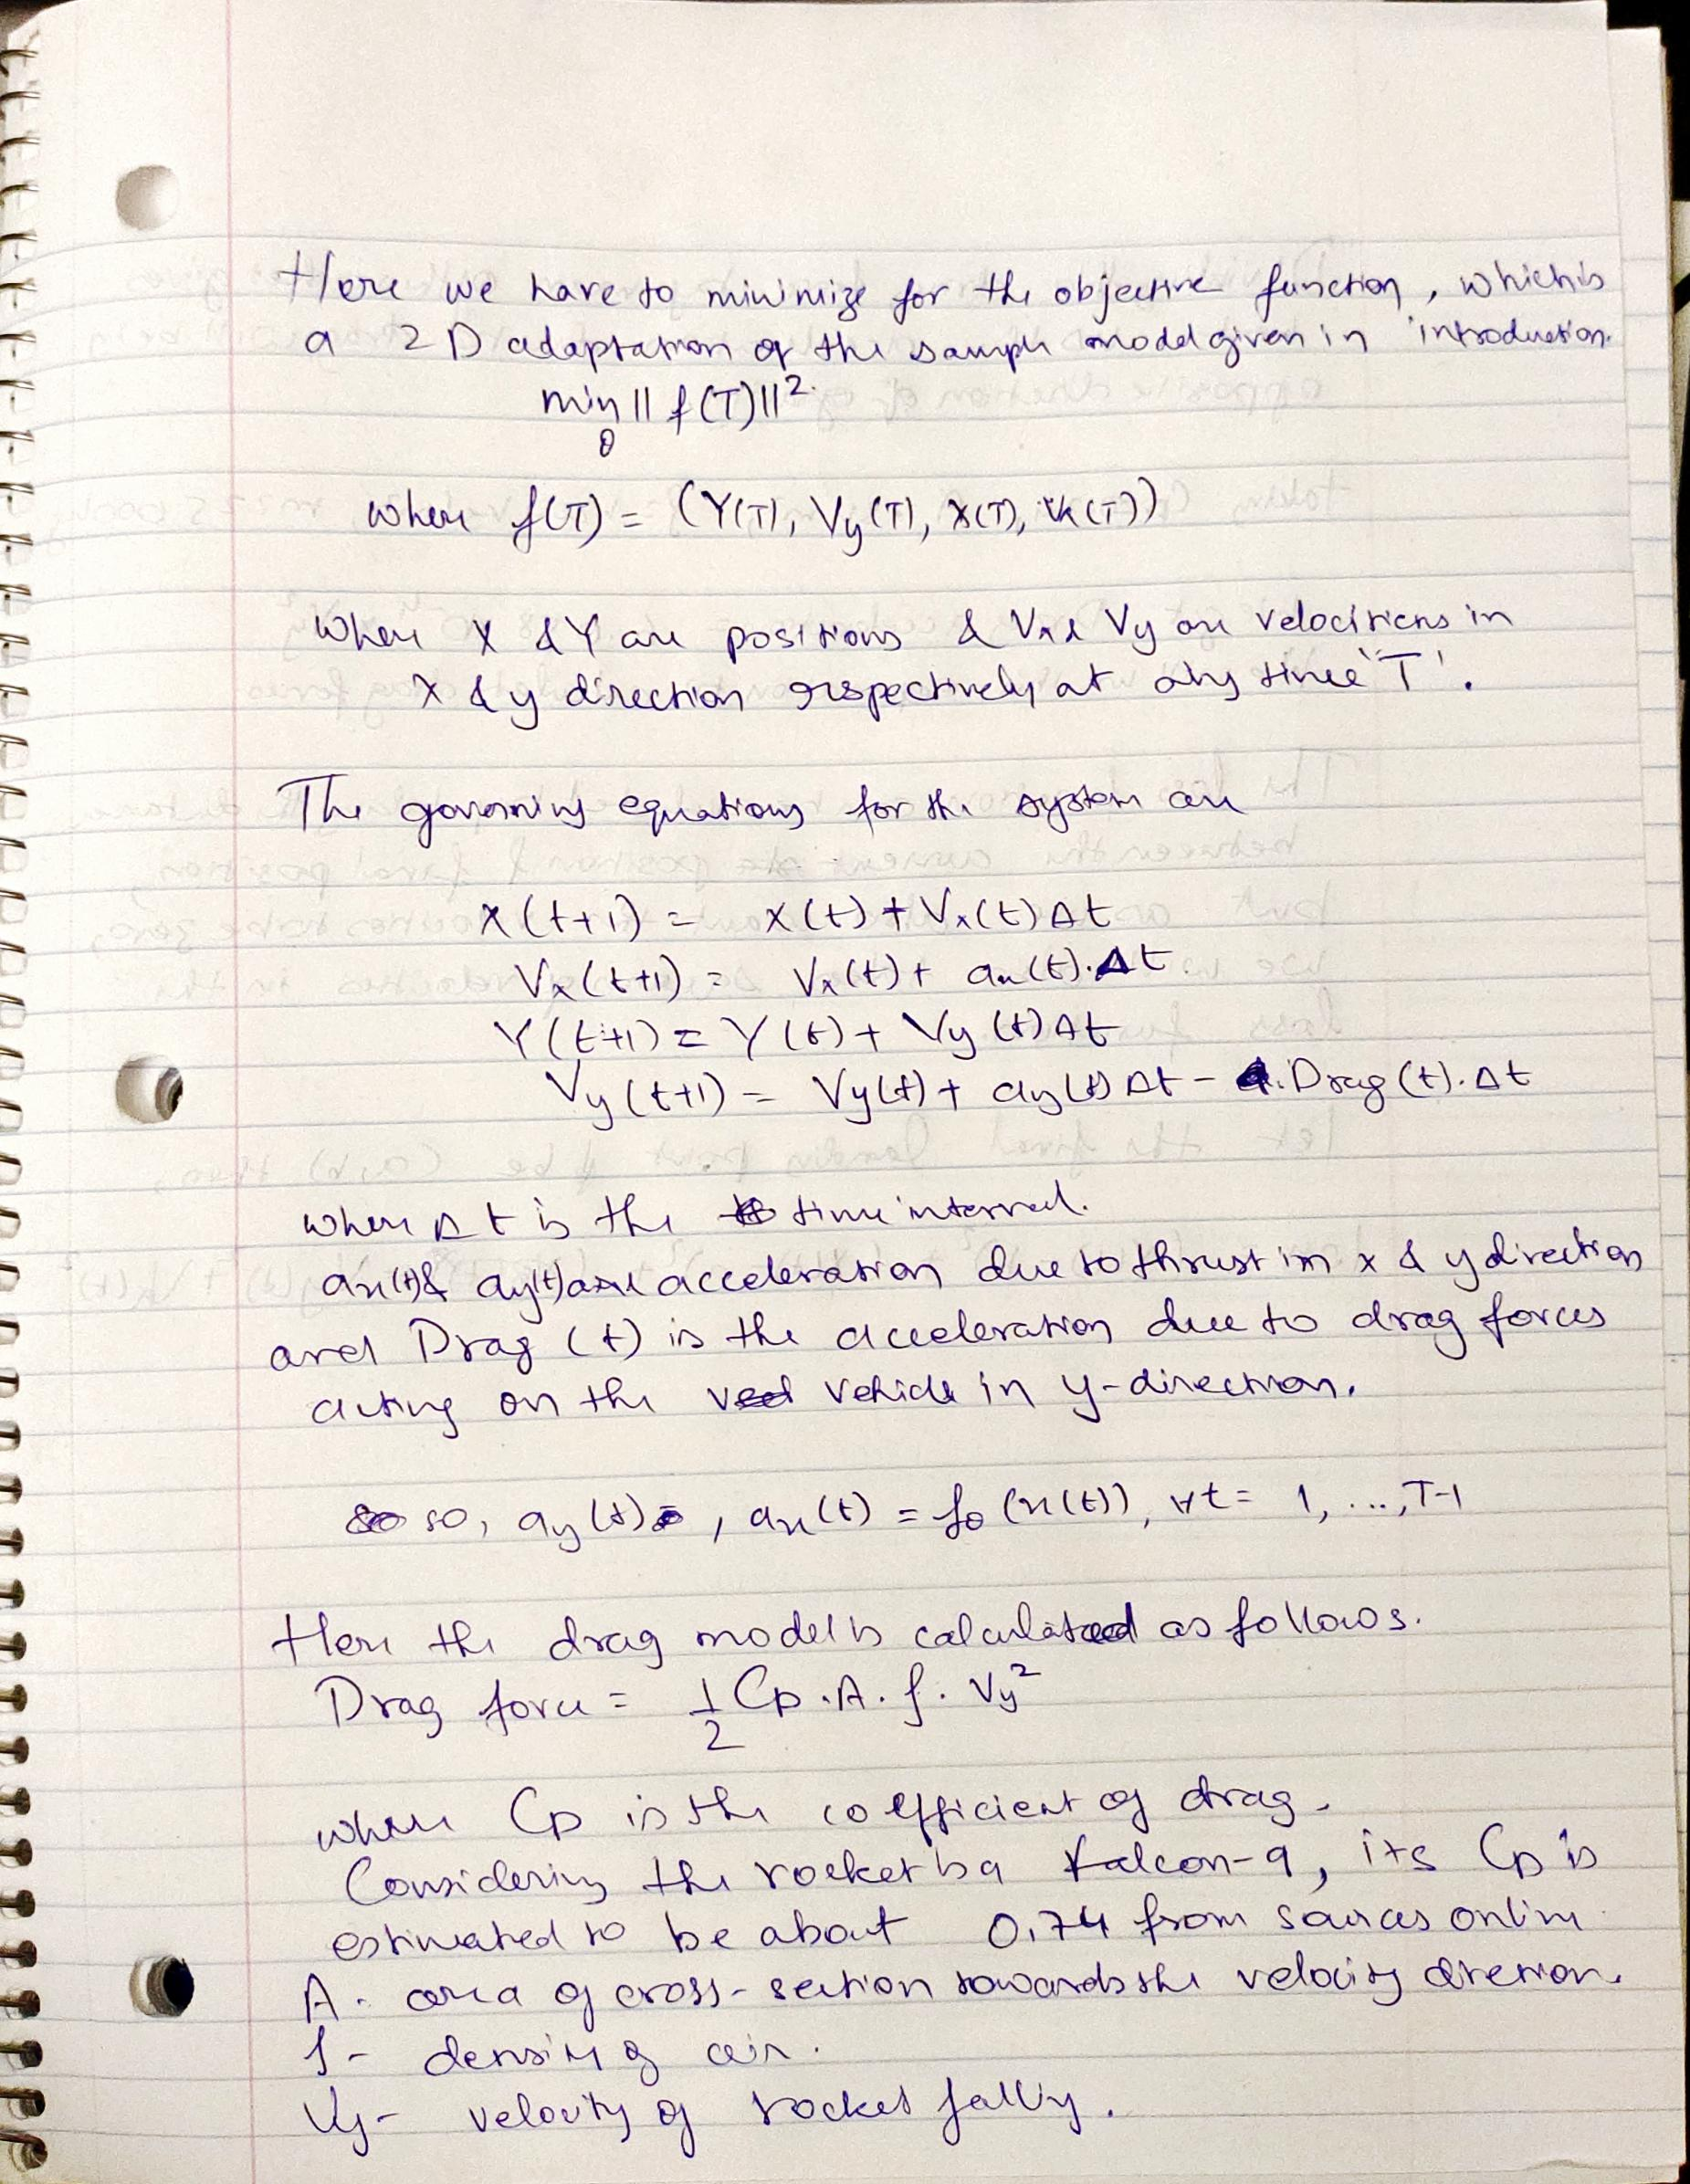

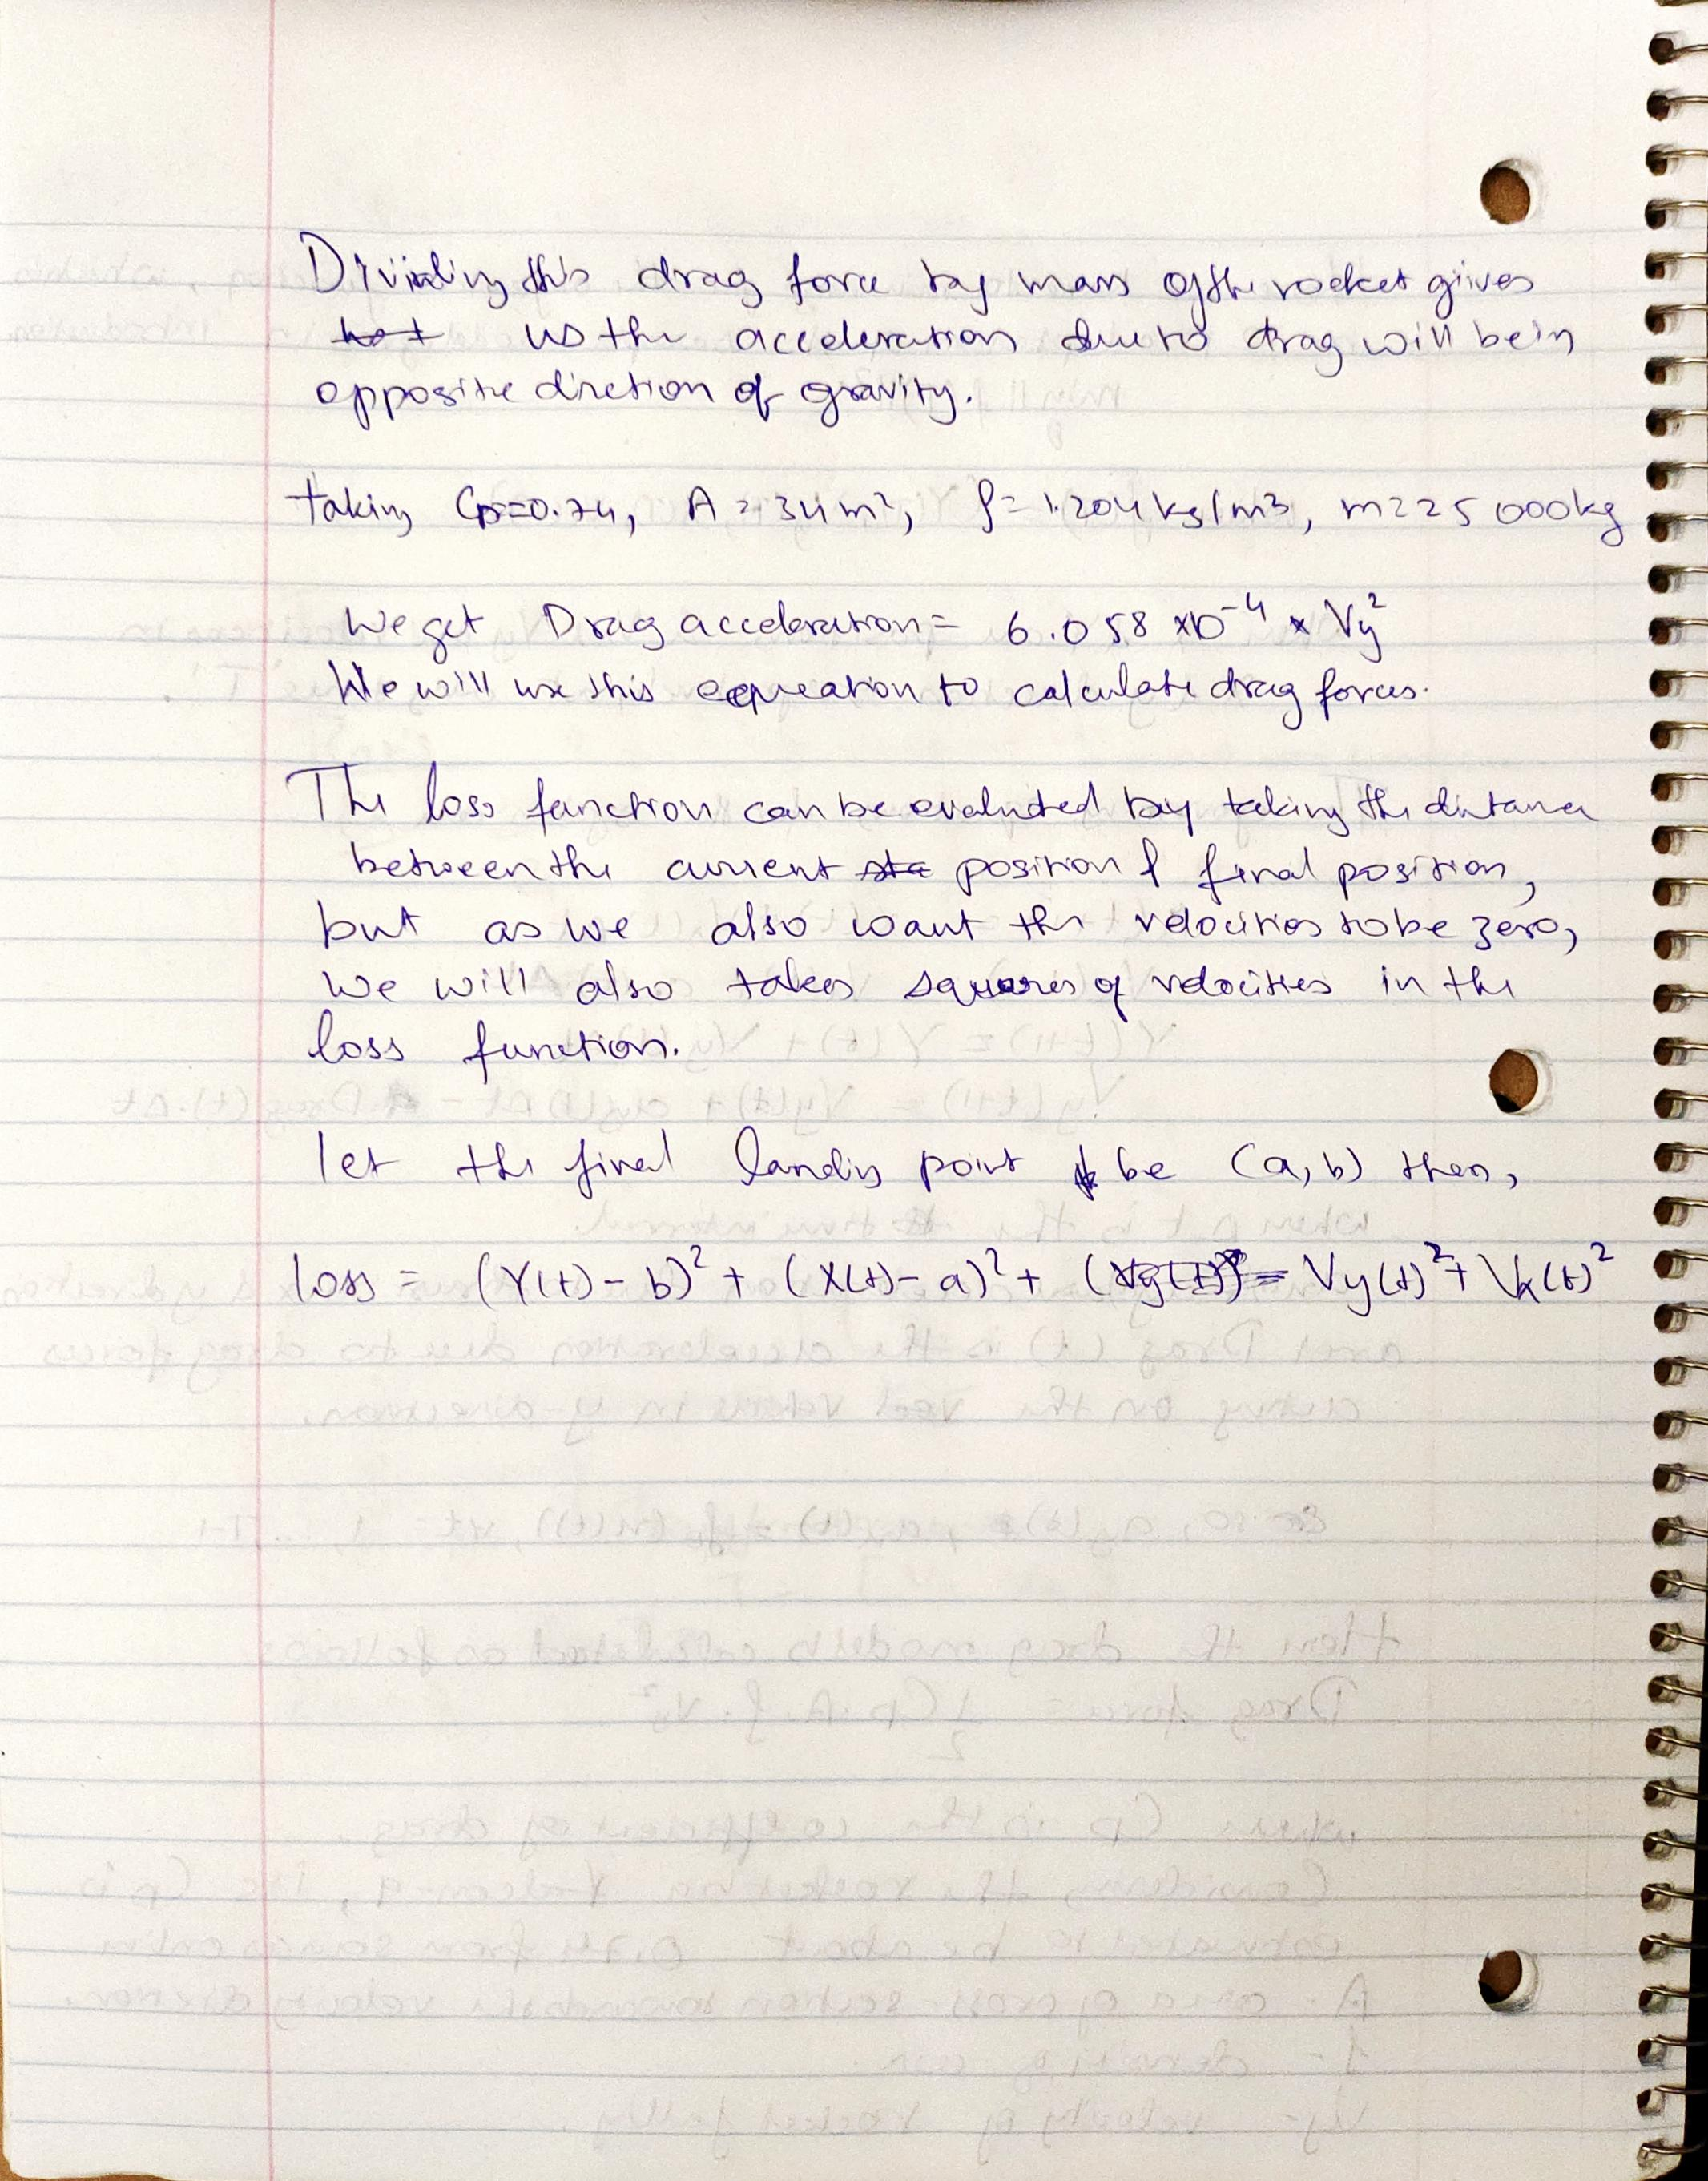

In [97]:
# overhead

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

In [98]:
# environment parameters

FRAME_TIME = 0.1  # Time interval
GRAVITY_ACCEL = 9.8  # gravitational constant g = 9.8 m/s^2
BOOST_ACCEL = 10  # Acceleration provided by the engine thrust in m/s^2 

# Additionally we will try to land the rocket on the point (-10,-10)
x_landing = -10
y_landing = -10

In [99]:
# Here we define the Dynamics that control the state of the rocket landing system

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        state[0] = y
        state[1] = y_dot
        state[2] = x
        state[3] = x_dot

        action: thrust or no thrust
        action[0] = y thrust
        action[1] = x thrust
        """
       
        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., gravity * delta_time], and do x = x + dx. This is allowed... 
        delta_state_gravity = t.tensor([0., GRAVITY_ACCEL * FRAME_TIME, 0., 0.]) # velocity change due to gravity

        # Thrust
        # Note: Same reason as above. Need a 2-by-1 tensor.
        delta_state_thrust_y = BOOST_ACCEL * FRAME_TIME * t.tensor([0., -1., 0., 0.]) * action[0] # Velocity change due to thrust in y-direction
        x_dot = BOOST_ACCEL * FRAME_TIME * t.tensor([0., 0., 0., 1.]) * action[1]  # Velocity change due to thrust in x-direction
        
        y_velo = delta_state_gravity + delta_state_thrust_y # Net velocity from the affect of both gravity and thrust
        
        # Drag as calculated depending on the velocity in y direction only
        ## We neglect the drag in x-direction
        # Drag is directly dependant on the square of velocity
        DRAG_ACCEL = 0.0006058 * (y_velo**2)

        # Calculating the new y_dot(y velocity) due to thrust and drag only
        y_dot = (BOOST_ACCEL - DRAG_ACCEL) * FRAME_TIME * t.tensor([0., -1., 0., 0.]) * action[0]

        # Update velocities
        state = state + y_dot + delta_state_gravity + x_dot
        
        # Update state
        # Note: Same as above. Use operators on matrices/tensors as much as possible. Do not use element-wise operators as they are considered inplace.
        step_mat = t.tensor([[1., FRAME_TIME, 0., 0.],
                            [0., 1., 0., 0.],
                            [0., 0., 1., FRAME_TIME],
                            [0., 0., 0., 1.]])
        state = t.matmul(step_mat, state)

        return state

In [100]:
# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),# added new layers
            nn.Linear(dim_hidden, dim_output),
            # You can add more layers here
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

In [101]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        # The initial state of the rocket is defined below
        # Initial point of the rocket is (15,55)
        # Initial velocity of the rocket is (-10,-10)
        state = [55., -10., 15., -10.]
        state = [a for a in state]
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        # The loss/error is calculated with respect to the final landing point 
        # and not w.r.t default (0,0)
        # This is done easily by substracting the co-ordinates and squaring them
        return ((state[0]-y_landing)**2) + (state[1]**2) + ((state[2]-x_landing)**2) + (state[3]**2)

In [102]:
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('-------------------')
            print('\nIteration:  ',epoch+1)
            print('loss: %.3f' % (loss))
            self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        y     = data[:, 0]
        y_dot = data[:, 1]
        x     = data[:, 2]
        x_dot = data[:, 3]
        
        fig, a1 = plt.subplots()
        a1.plot(y, y_dot)
        a1.set_title('Y_dot vs Y')
        a1.set_xlabel('Y')
        a1.set_ylabel('Y_dot')
        
        fig, a2 = plt.subplots()
        a2.plot(x, x_dot)
        a2.set_title('X_dot vs X')
        a2.set_xlabel('X')
        a2.set_ylabel('X_dot')
        plt.show()

        fig, a3 = plt.subplots()
        a3.plot(x, y)
        a3.set_title('Trajectory')
        a3.set_xlabel('X')
        a3.set_ylabel('Y')
        plt.show()

-------------------

Iteration:   1
loss: 23290.520


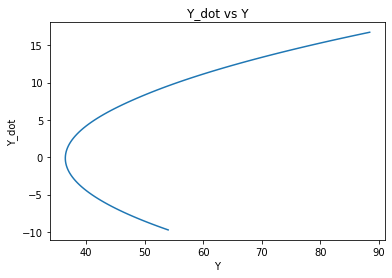

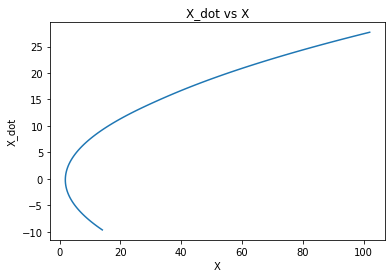

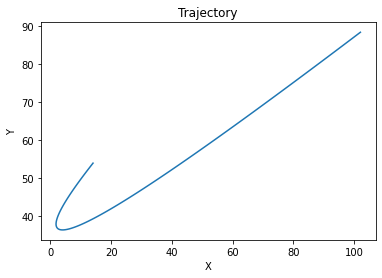

-------------------

Iteration:   2
loss: 11340.515


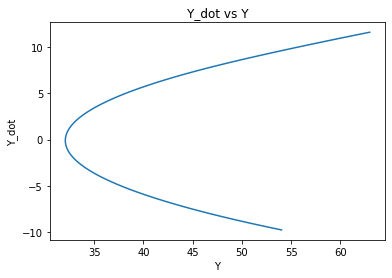

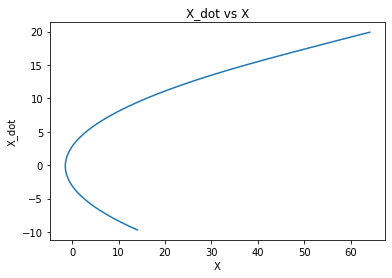

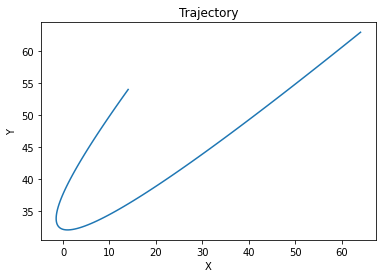

-------------------

Iteration:   3
loss: 5771.607


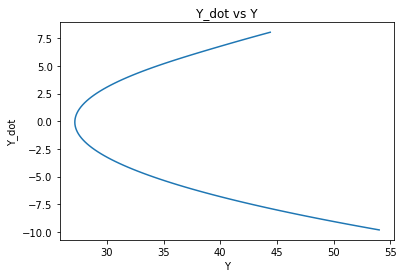

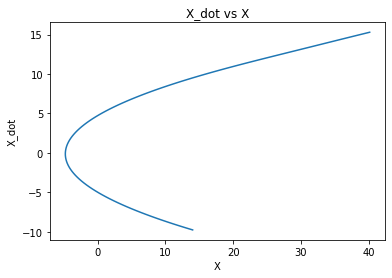

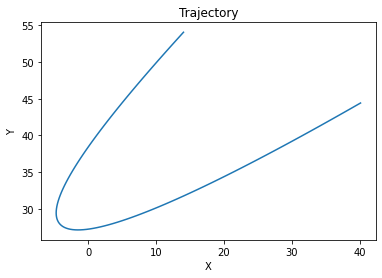

-------------------

Iteration:   4
loss: 3517.305


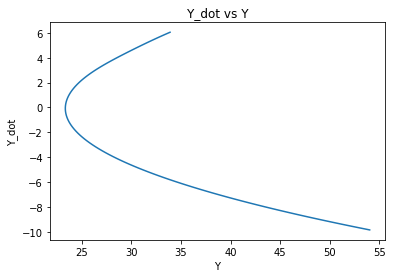

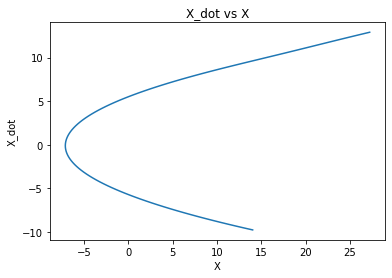

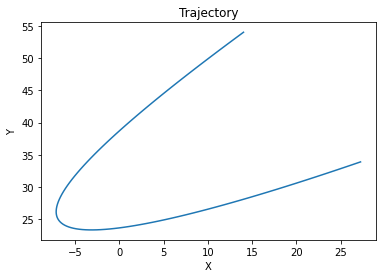

-------------------

Iteration:   5
loss: 2323.882


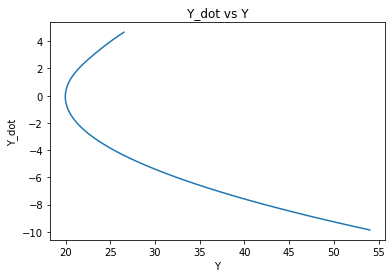

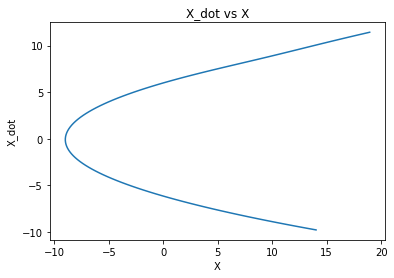

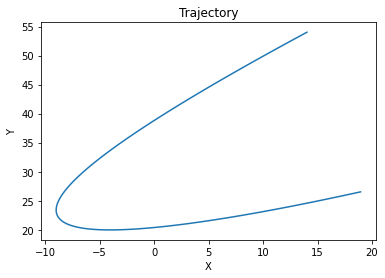

-------------------

Iteration:   6
loss: 1603.939


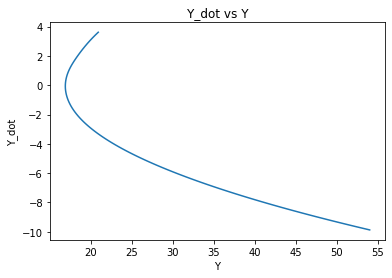

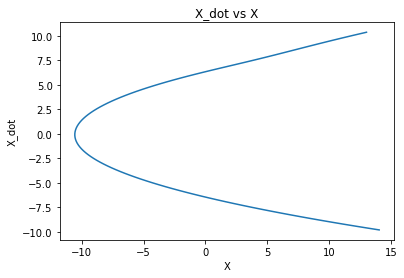

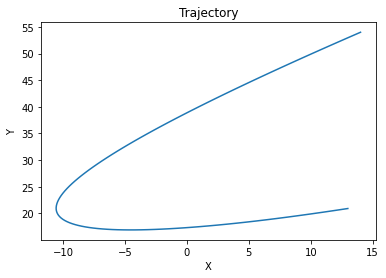

-------------------

Iteration:   7
loss: 1135.949


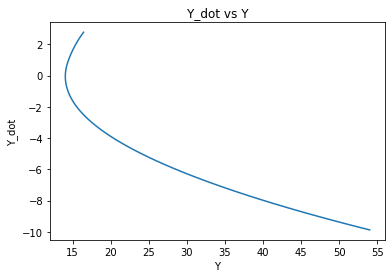

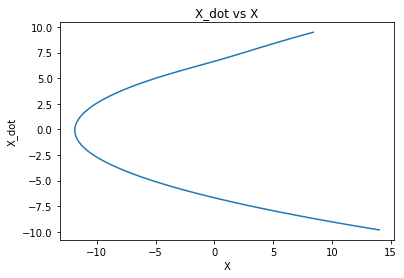

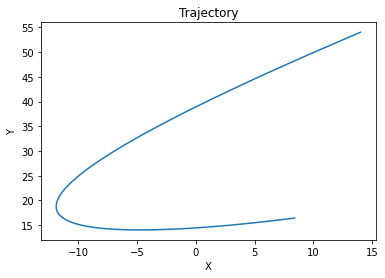

-------------------

Iteration:   8
loss: 835.330


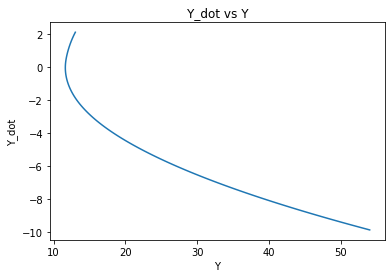

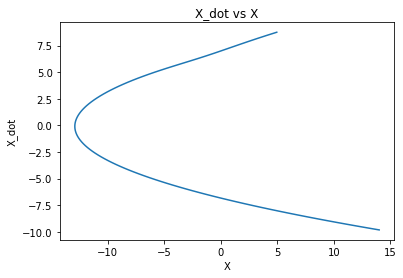

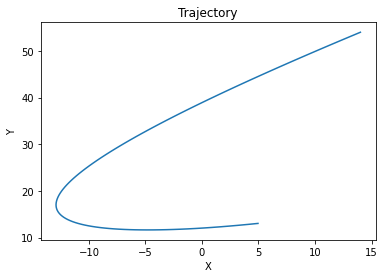

-------------------

Iteration:   9
loss: 610.055


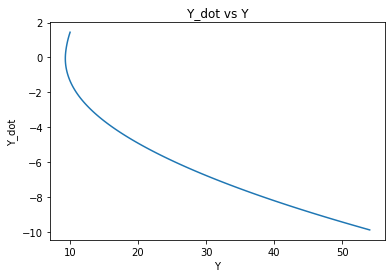

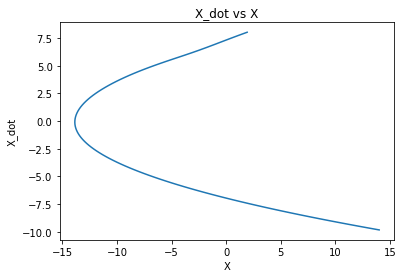

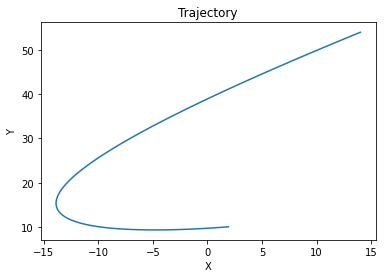

-------------------

Iteration:   10
loss: 425.412


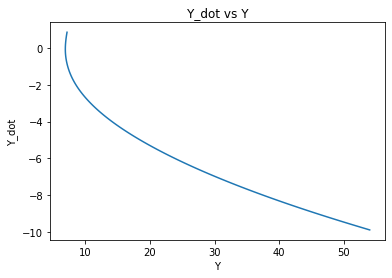

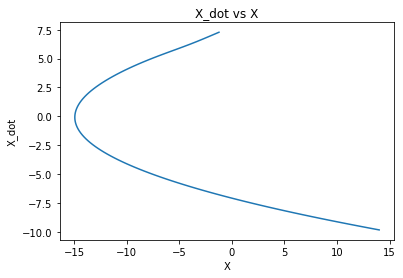

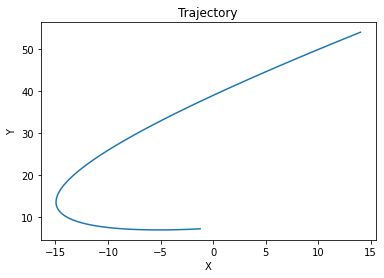

-------------------

Iteration:   11
loss: 292.662


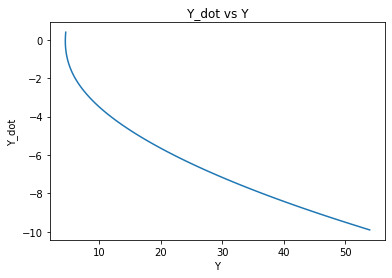

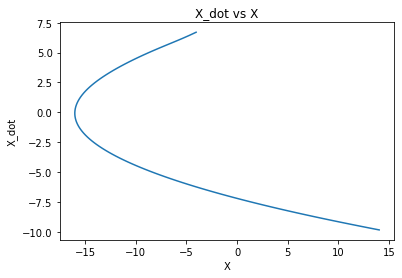

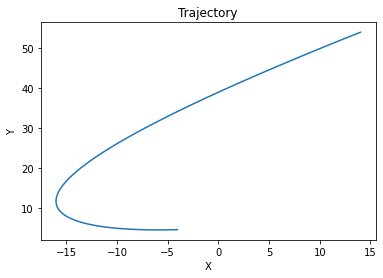

-------------------

Iteration:   12
loss: 205.094


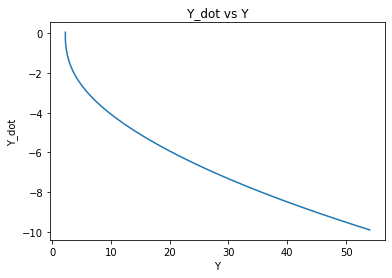

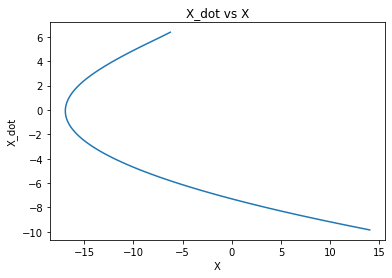

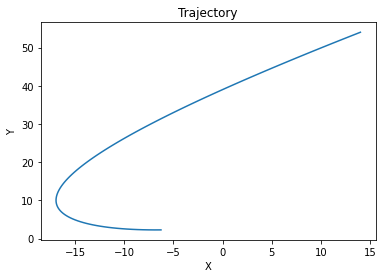

-------------------

Iteration:   13
loss: 144.200


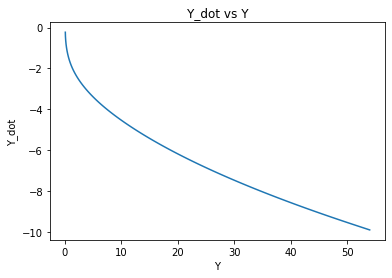

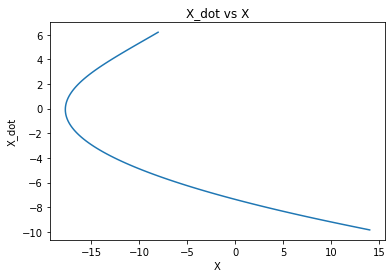

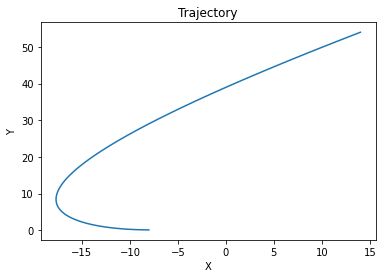

-------------------

Iteration:   14
loss: 97.867


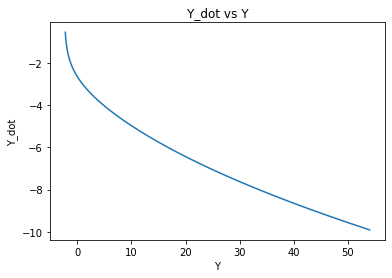

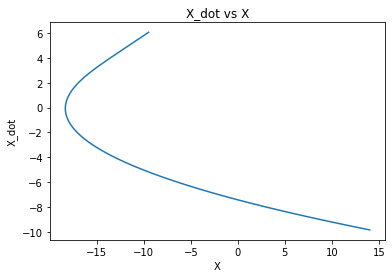

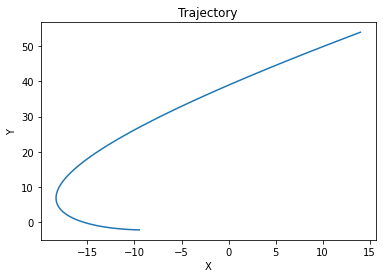

-------------------

Iteration:   15
loss: 68.107


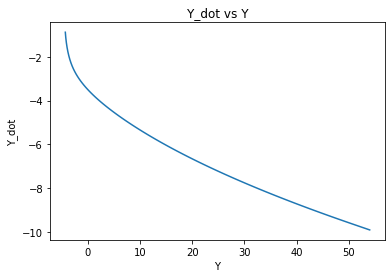

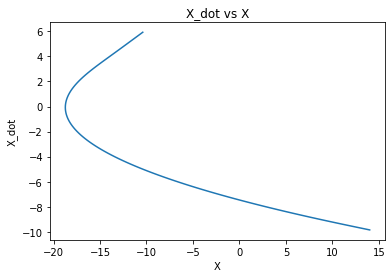

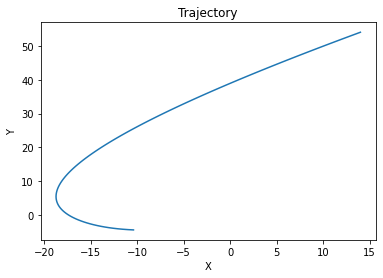

-------------------

Iteration:   16
loss: 49.514


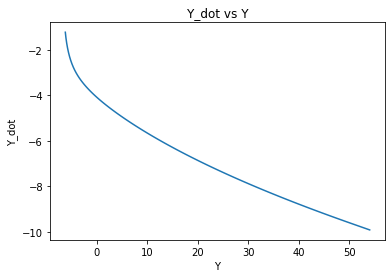

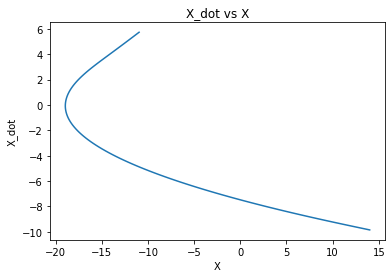

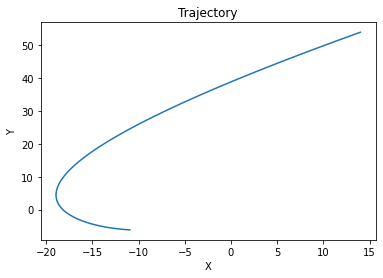

-------------------

Iteration:   17
loss: 41.274


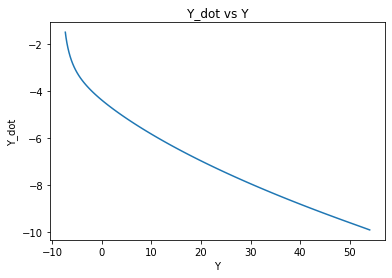

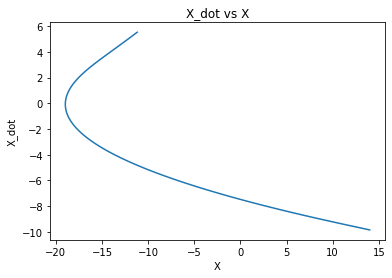

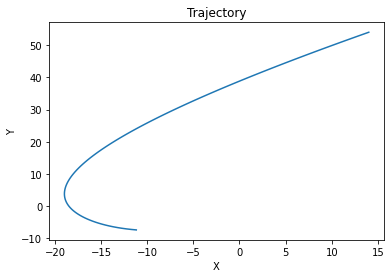

-------------------

Iteration:   18
loss: 34.955


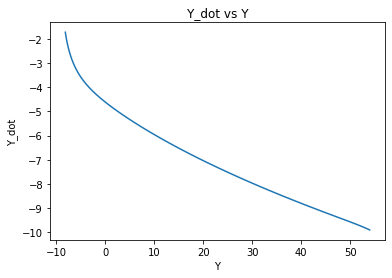

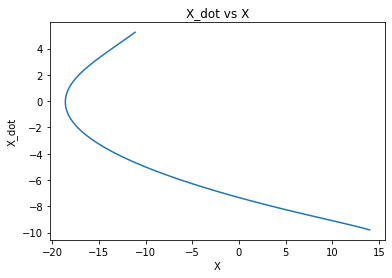

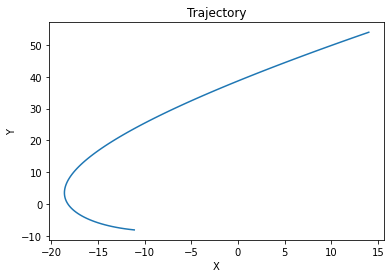

-------------------

Iteration:   19
loss: 26.505


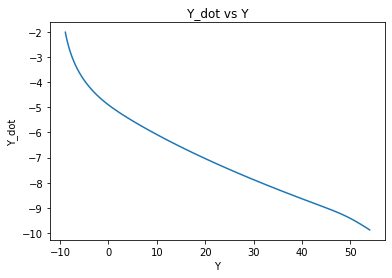

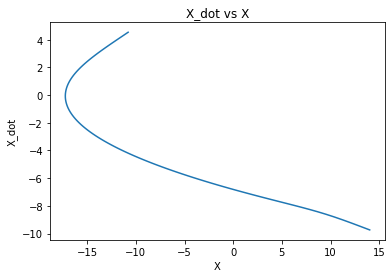

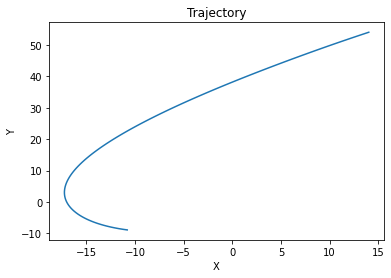

-------------------

Iteration:   20
loss: 19.325


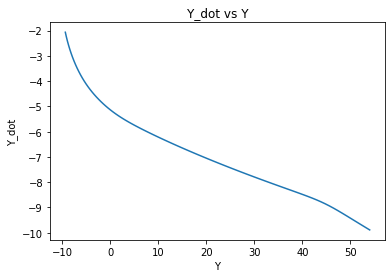

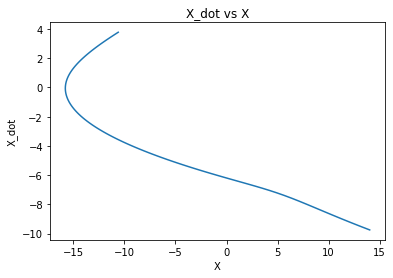

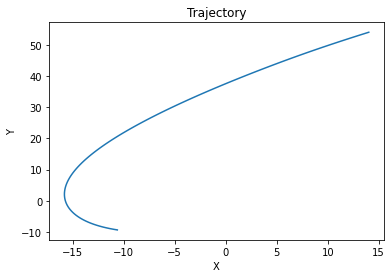

-------------------

Iteration:   21
loss: 11.840


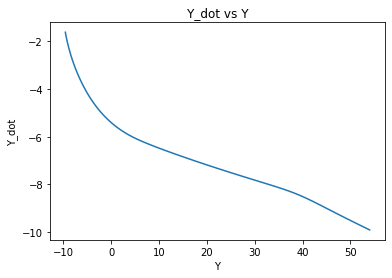

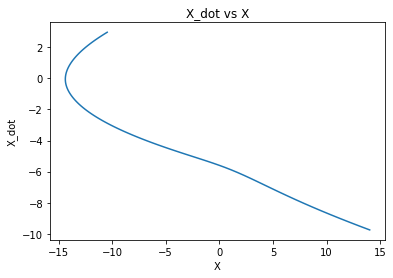

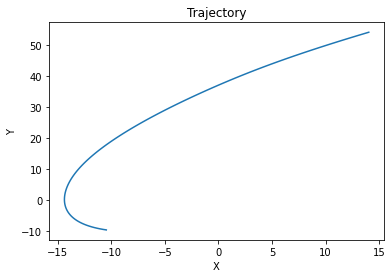

-------------------

Iteration:   22
loss: 7.784


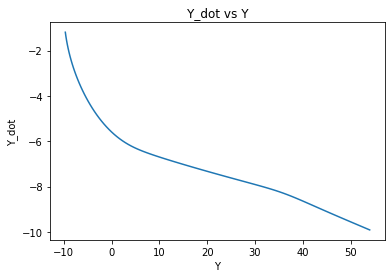

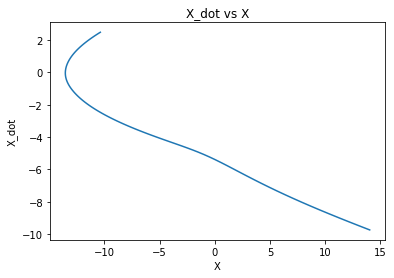

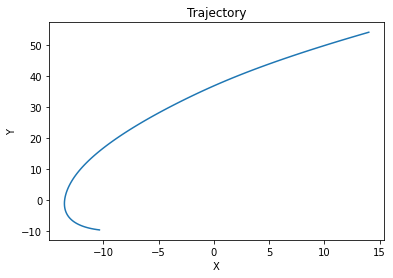

-------------------

Iteration:   23
loss: 5.611


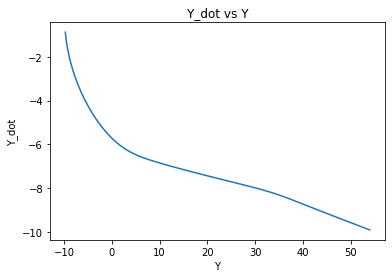

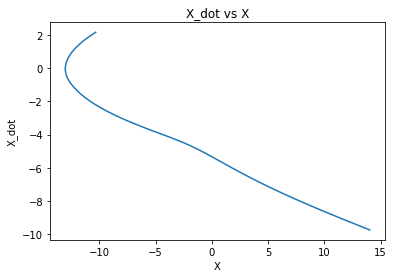

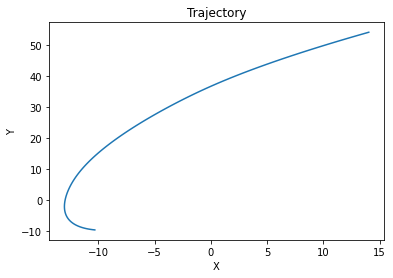

-------------------

Iteration:   24
loss: 4.188


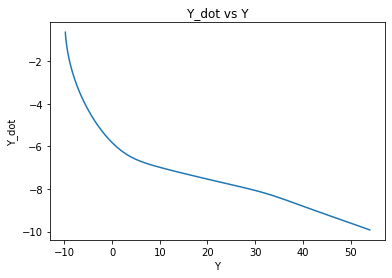

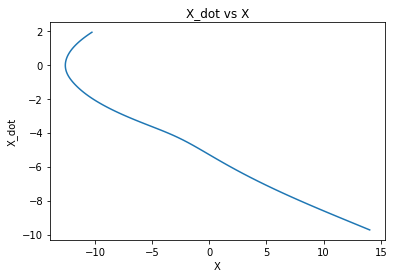

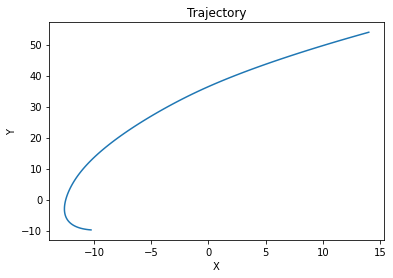

-------------------

Iteration:   25
loss: 3.183


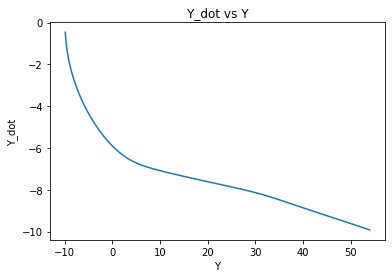

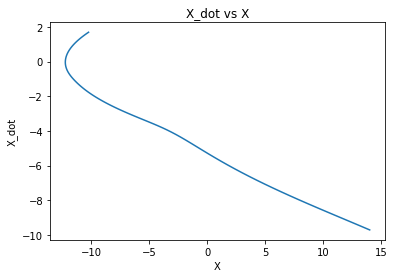

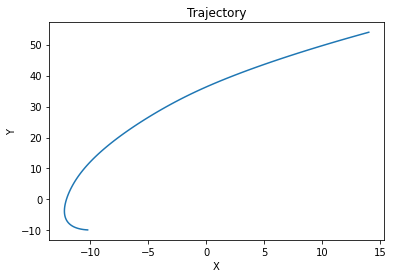

-------------------

Iteration:   26
loss: 2.447


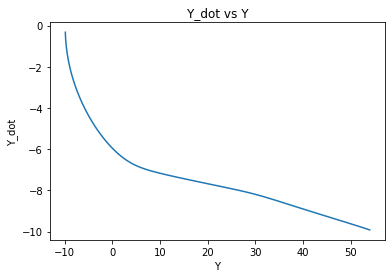

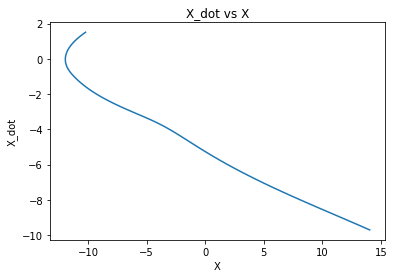

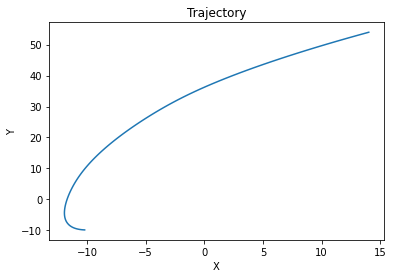

-------------------

Iteration:   27
loss: 1.906


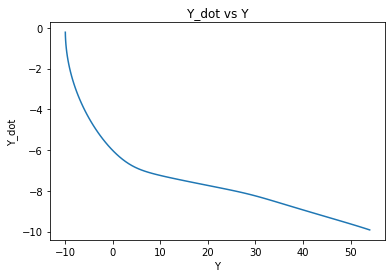

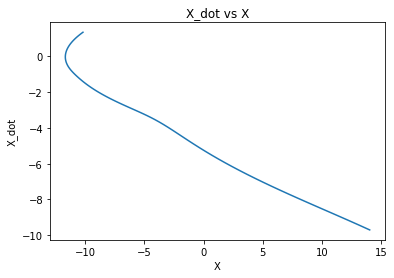

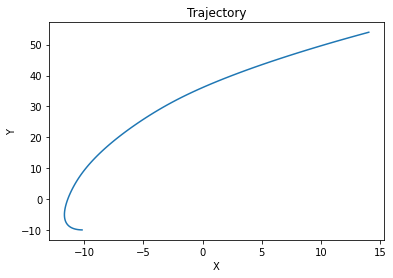

-------------------

Iteration:   28
loss: 1.505


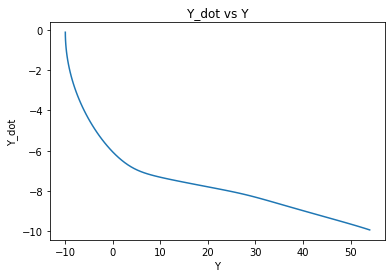

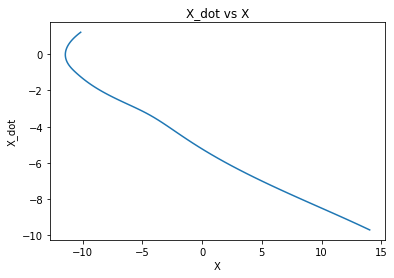

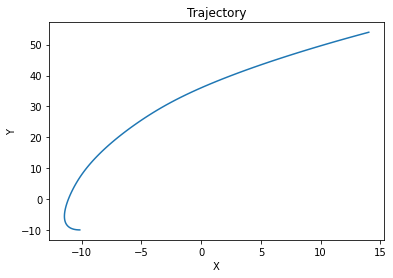

-------------------

Iteration:   29
loss: 1.201


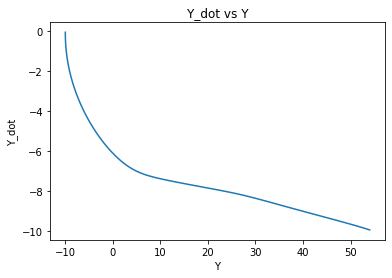

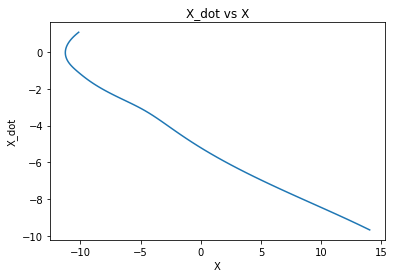

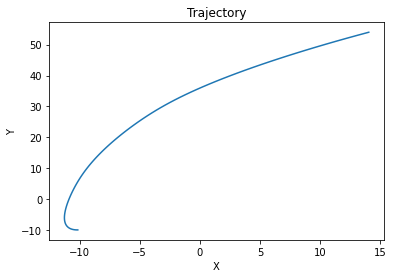

-------------------

Iteration:   30
loss: 0.968


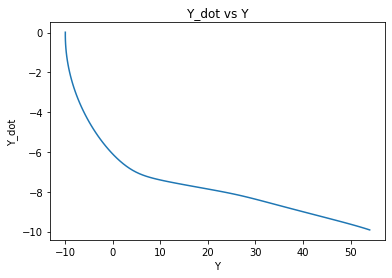

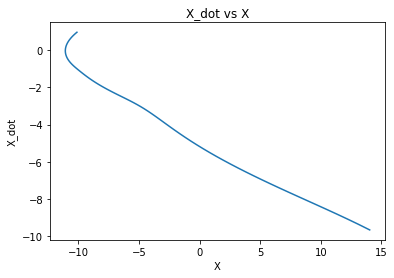

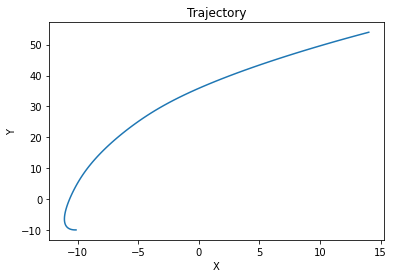

-------------------

Iteration:   31
loss: 0.786


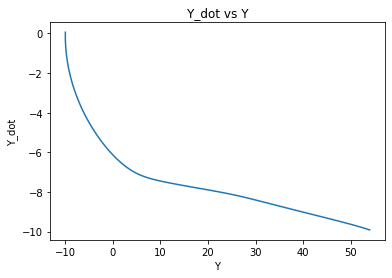

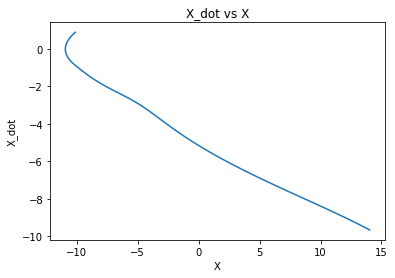

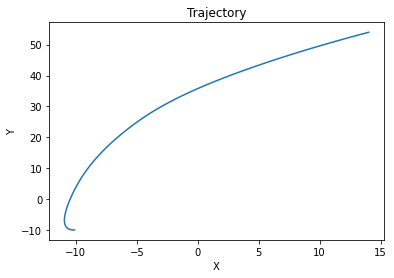

-------------------

Iteration:   32
loss: 0.644


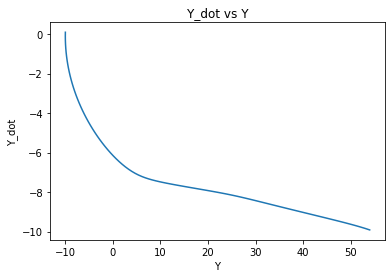

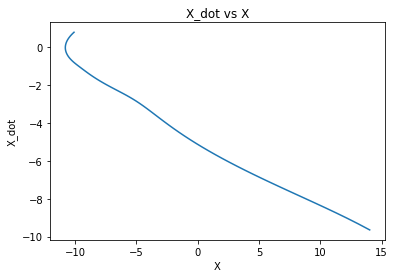

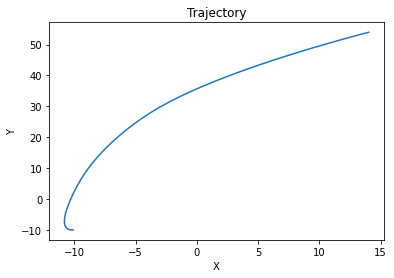

-------------------

Iteration:   33
loss: 0.527


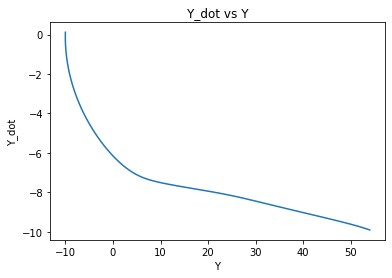

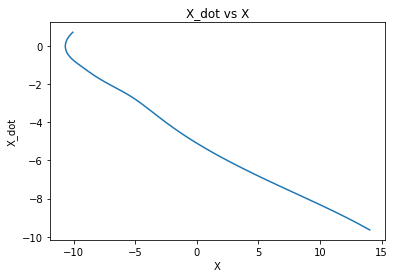

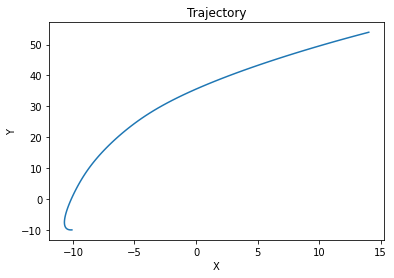

-------------------

Iteration:   34
loss: 0.431


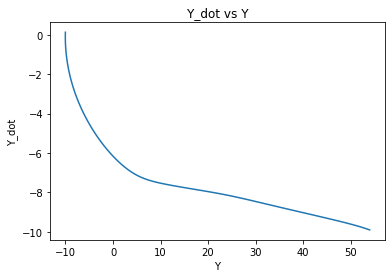

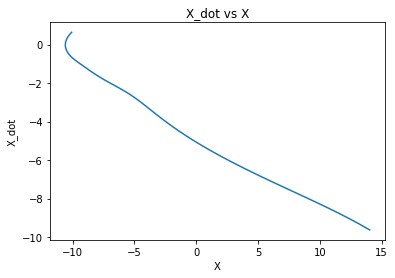

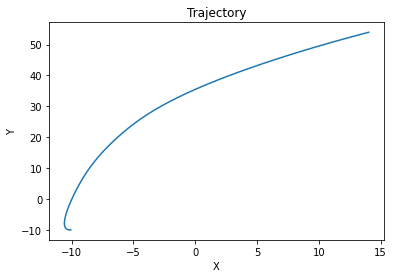

-------------------

Iteration:   35
loss: 0.349


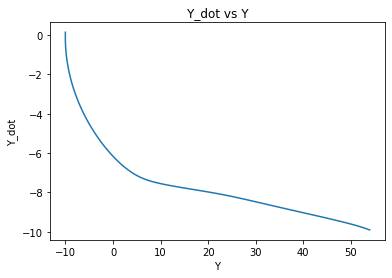

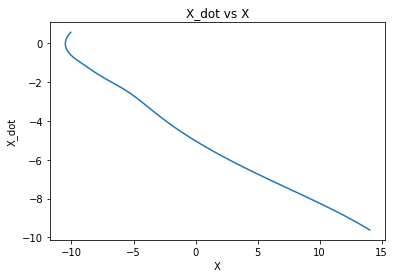

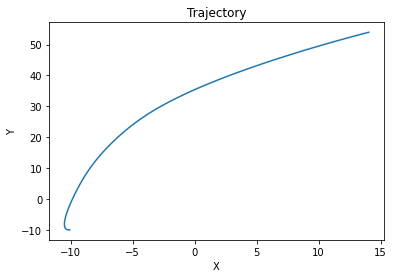

-------------------

Iteration:   36
loss: 0.281


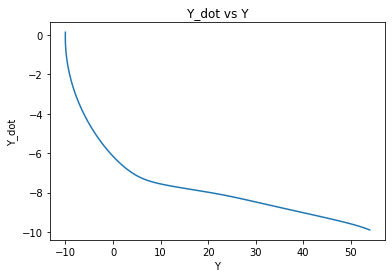

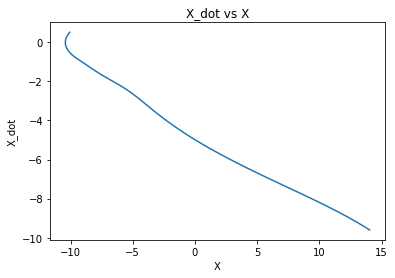

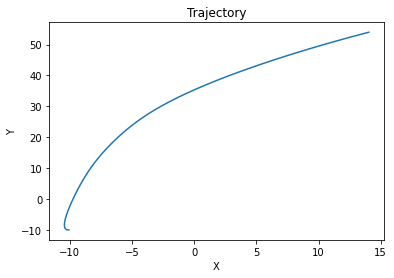

-------------------

Iteration:   37
loss: 0.224


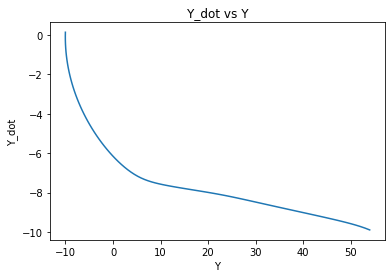

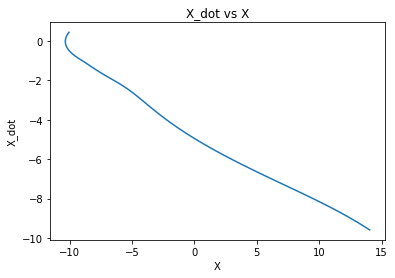

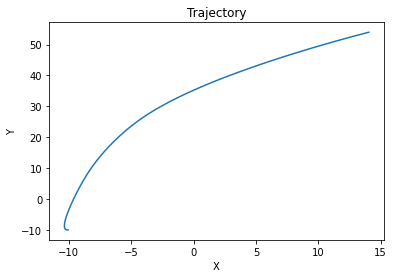

-------------------

Iteration:   38
loss: 0.176


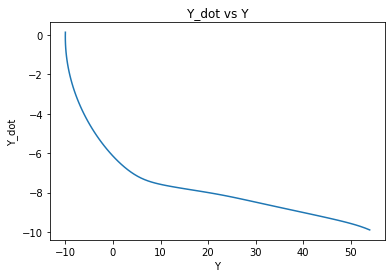

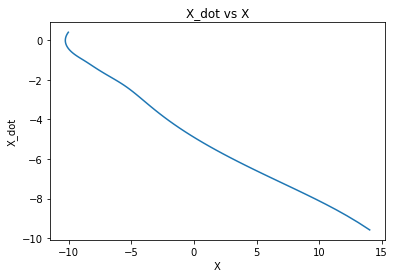

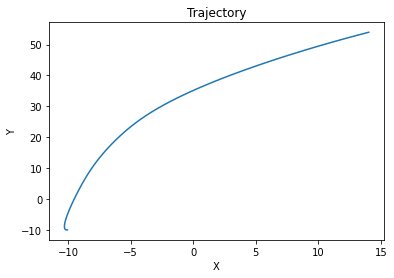

-------------------

Iteration:   39
loss: 0.136


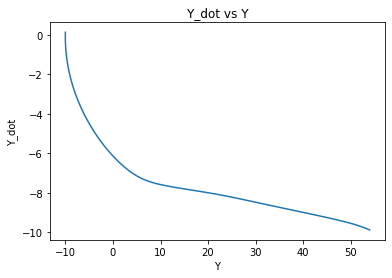

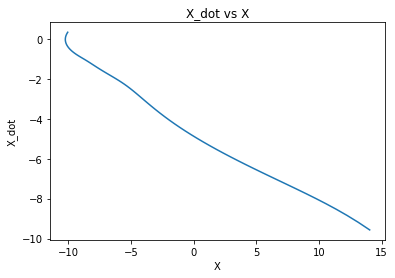

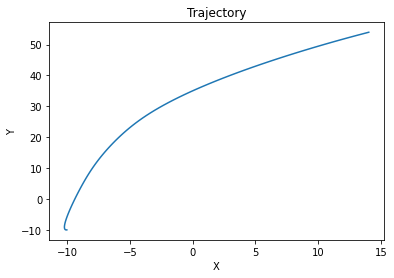

-------------------

Iteration:   40
loss: 0.105


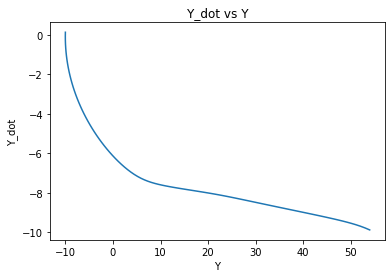

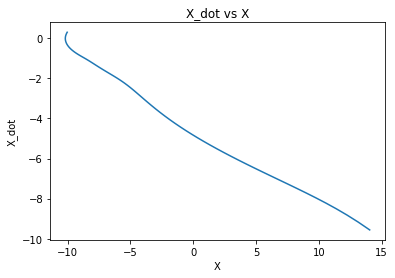

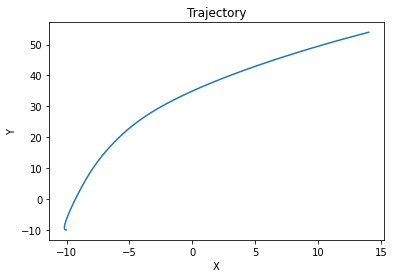

-------------------

Iteration:   41
loss: 0.080


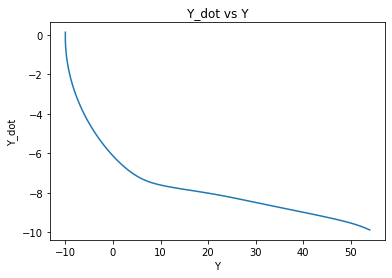

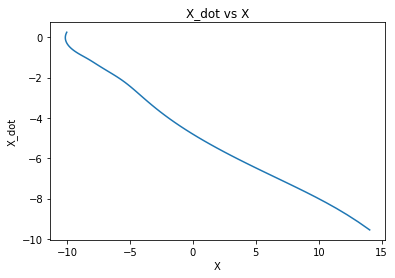

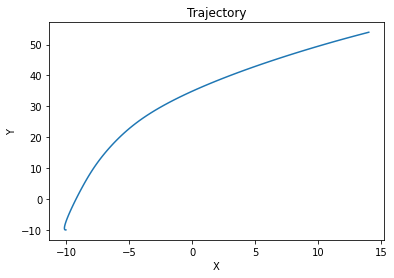

-------------------

Iteration:   42
loss: 0.059


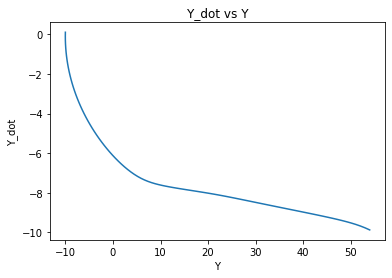

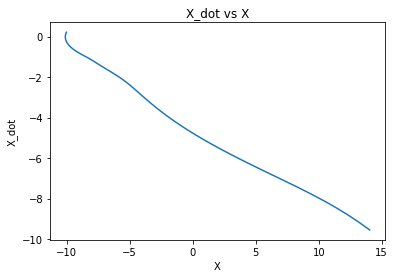

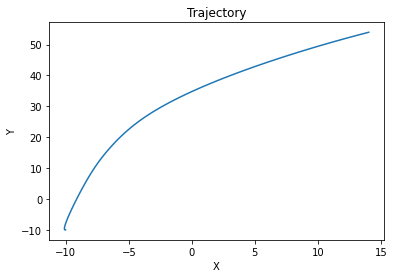

-------------------

Iteration:   43
loss: 0.042


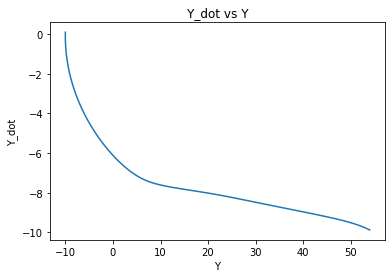

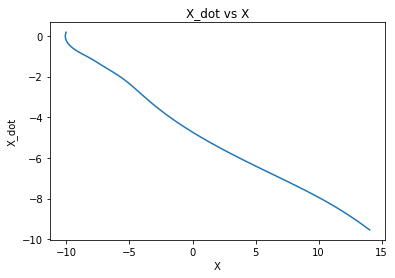

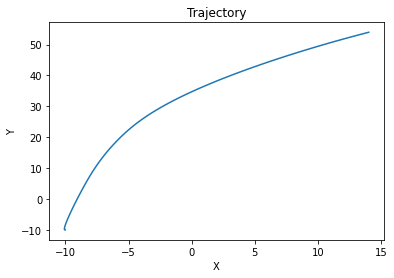

-------------------

Iteration:   44
loss: 0.029


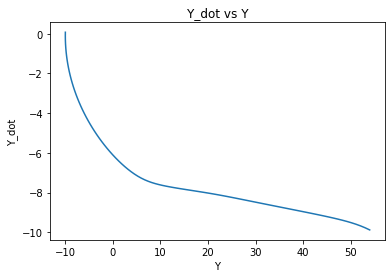

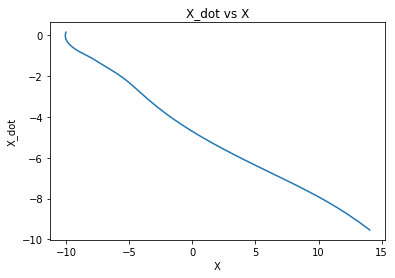

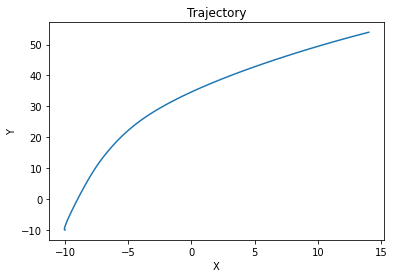

-------------------

Iteration:   45
loss: 0.020


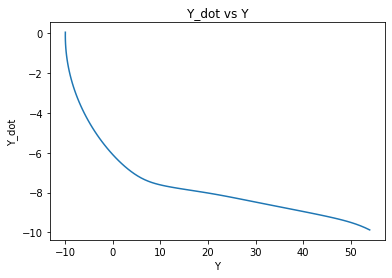

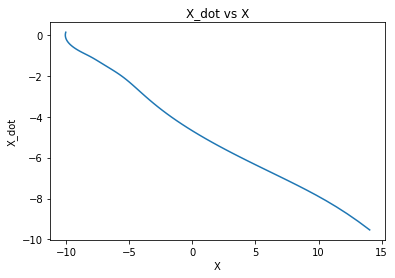

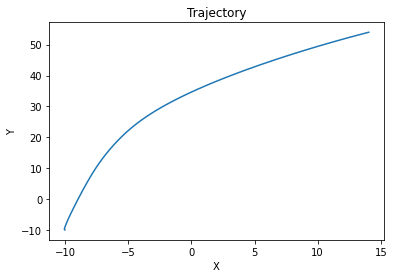

-------------------

Iteration:   46
loss: 0.014


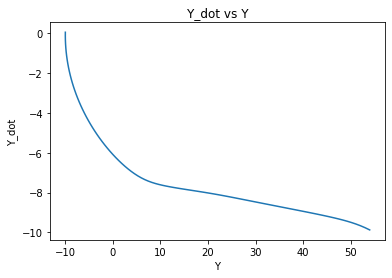

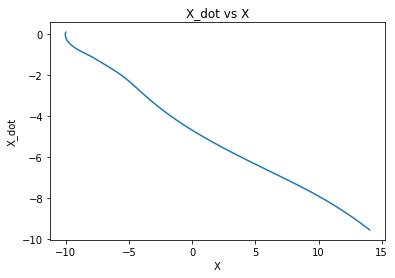

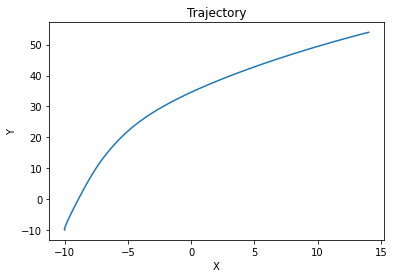

-------------------

Iteration:   47
loss: 0.009


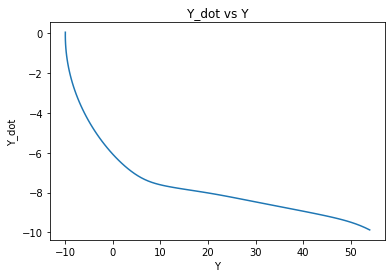

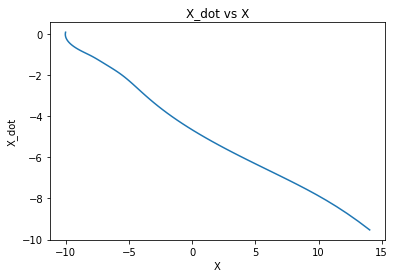

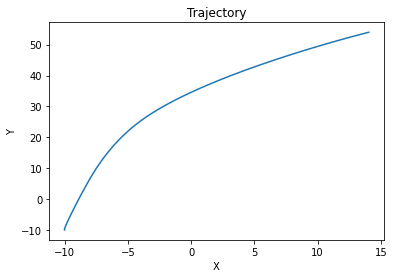

-------------------

Iteration:   48
loss: 0.006


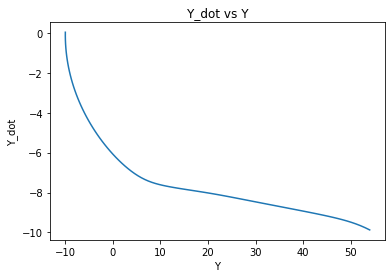

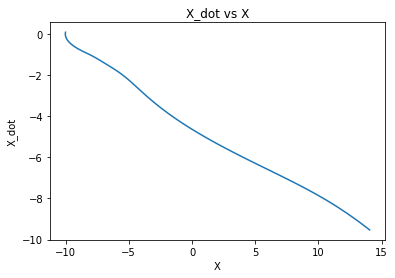

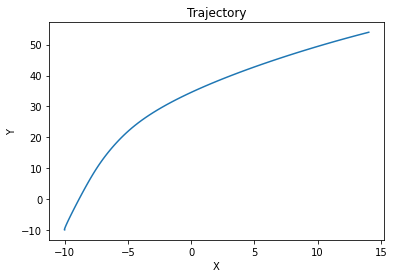

-------------------

Iteration:   49
loss: 0.004


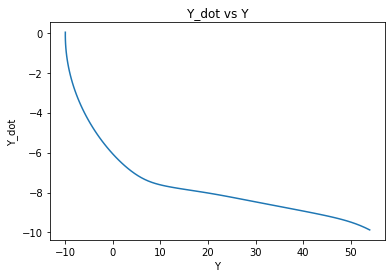

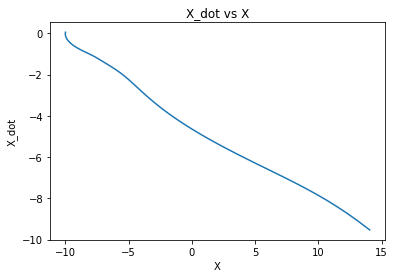

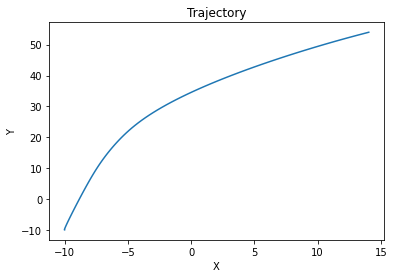

-------------------

Iteration:   50
loss: 0.003


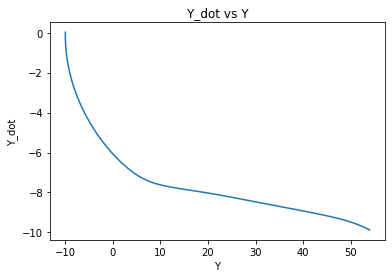

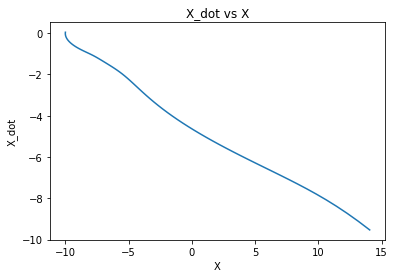

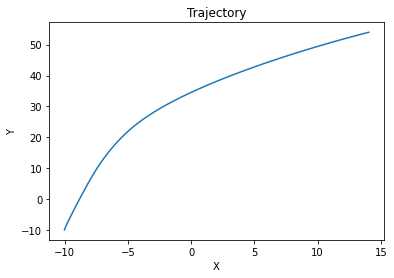

-------------------

Iteration:   51
loss: 0.002


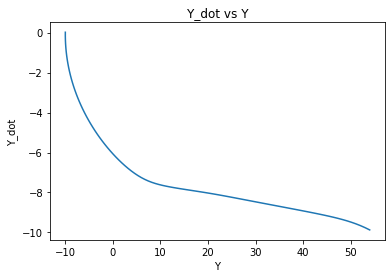

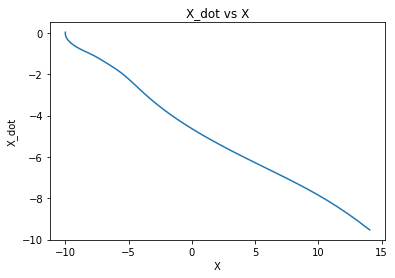

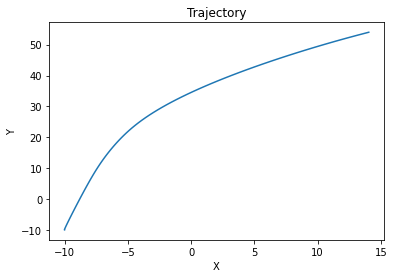

-------------------

Iteration:   52
loss: 0.001


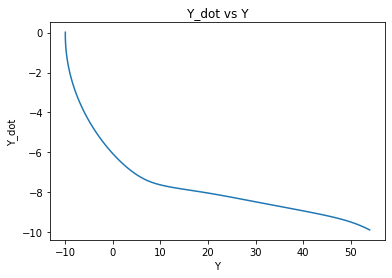

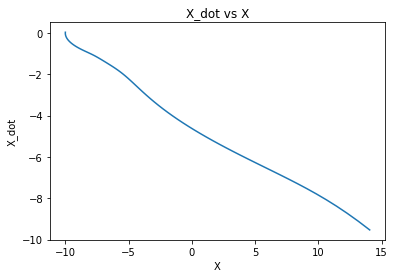

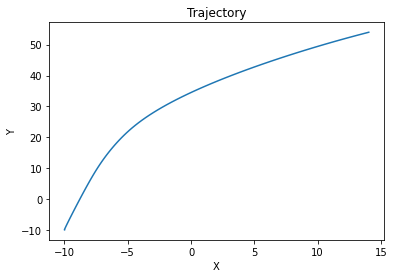

-------------------

Iteration:   53
loss: 0.001


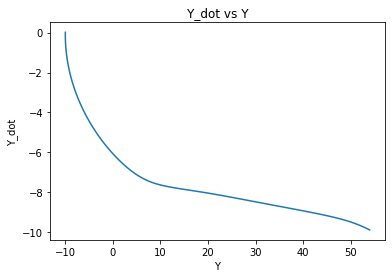

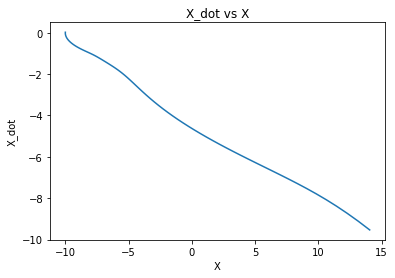

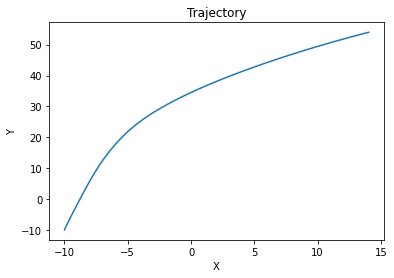

-------------------

Iteration:   54
loss: 0.000


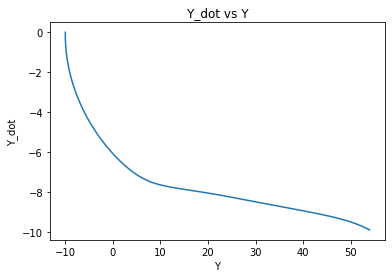

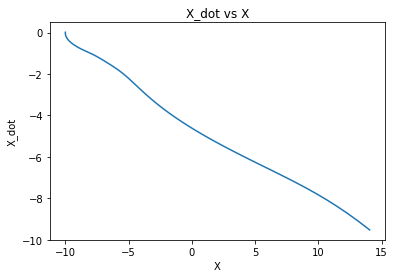

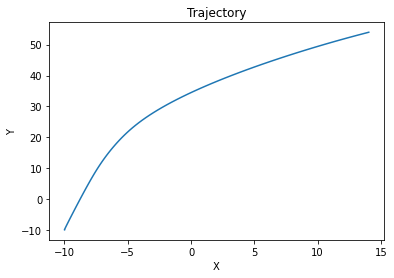

-------------------

Iteration:   55
loss: 0.000


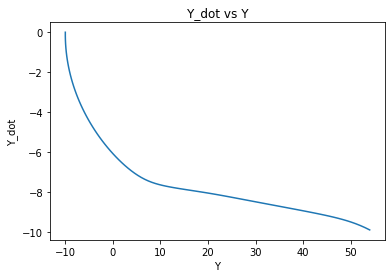

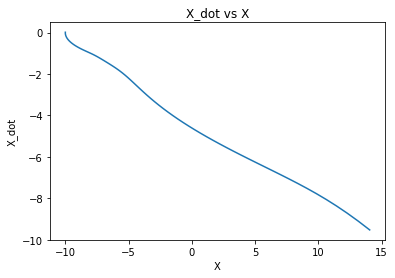

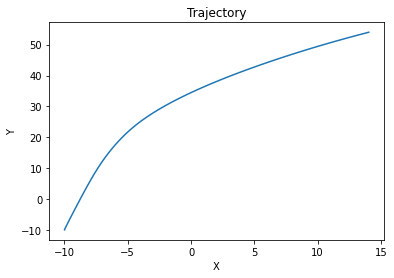

-------------------

Iteration:   56
loss: 0.000


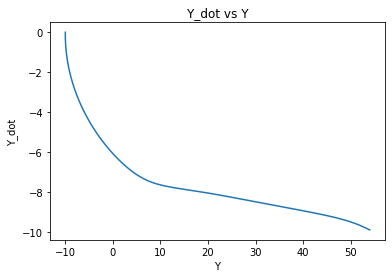

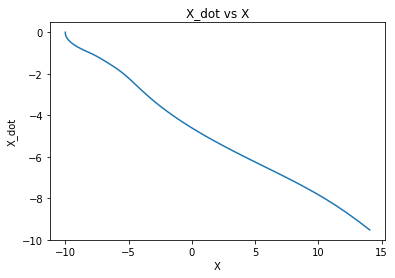

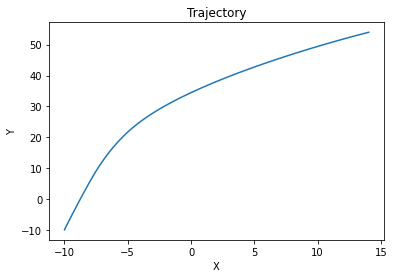

-------------------

Iteration:   57
loss: 0.000


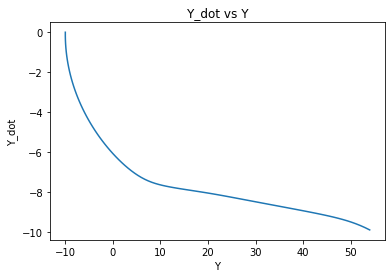

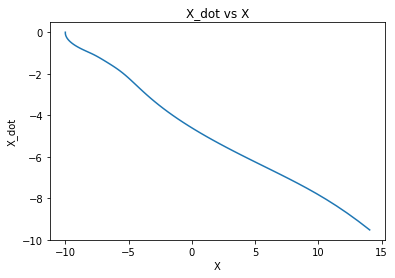

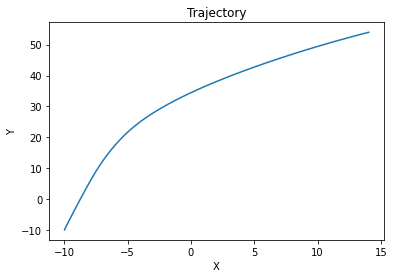

-------------------

Iteration:   58
loss: 0.000


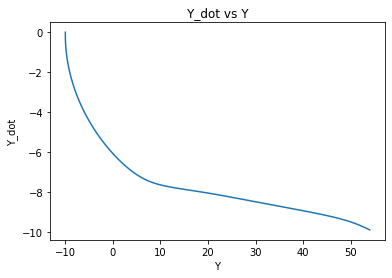

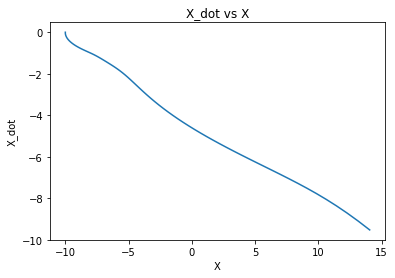

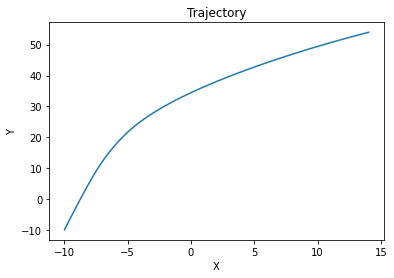

-------------------

Iteration:   59
loss: 0.000


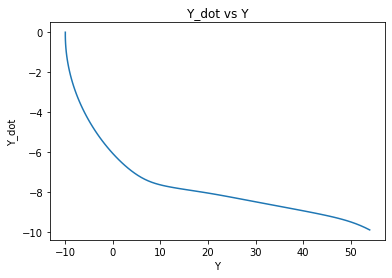

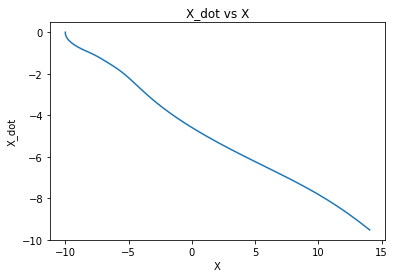

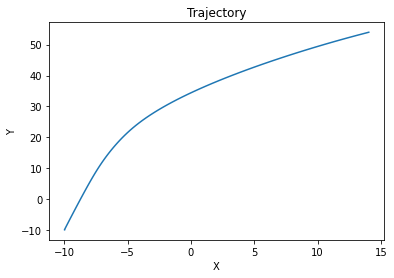

-------------------

Iteration:   60
loss: 0.621


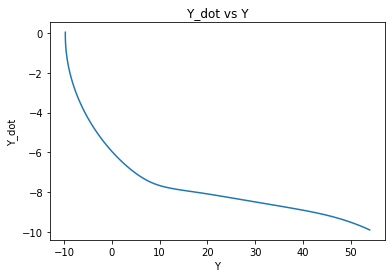

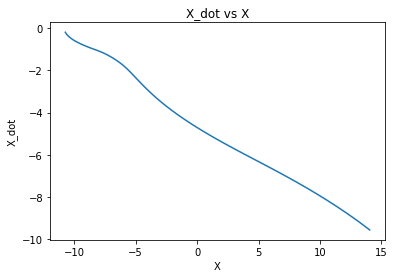

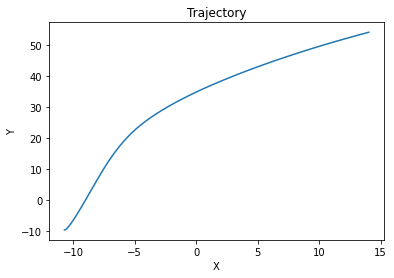

-------------------

Iteration:   61
loss: 0.064


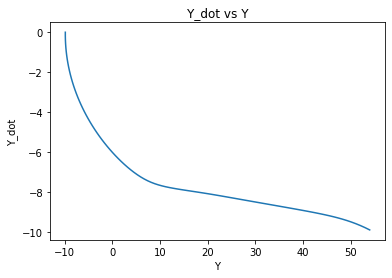

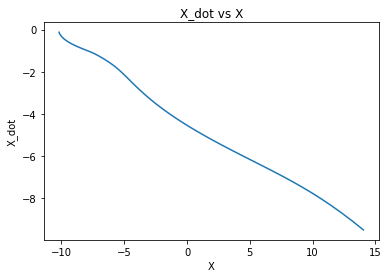

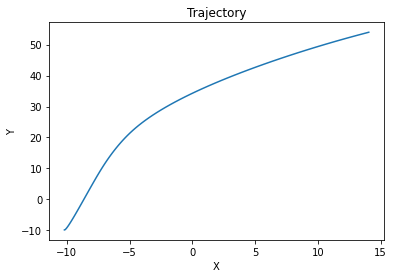

-------------------

Iteration:   62
loss: 0.036


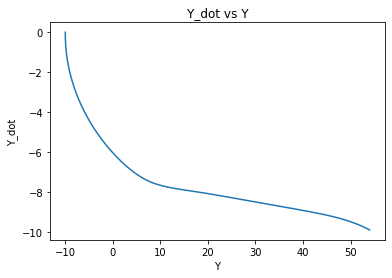

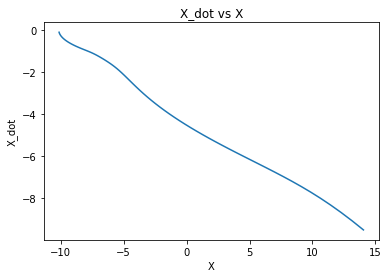

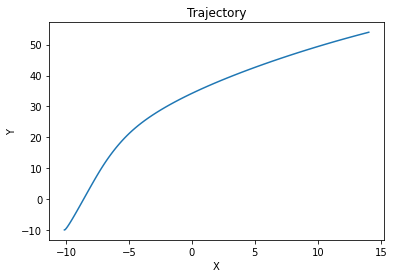

-------------------

Iteration:   63
loss: 0.018


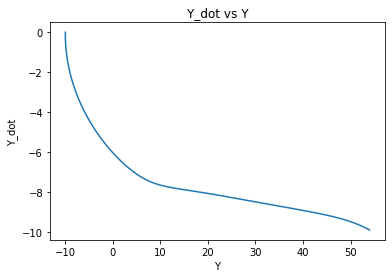

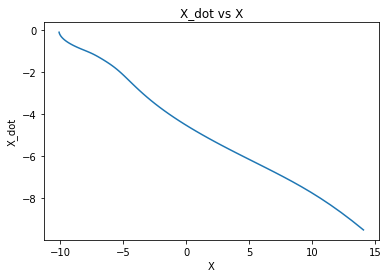

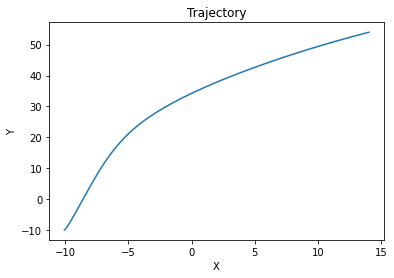

-------------------

Iteration:   64
loss: 0.011


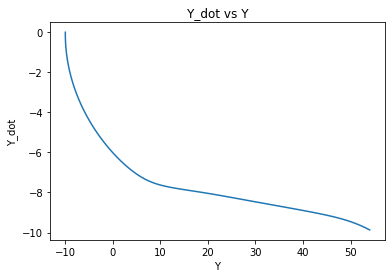

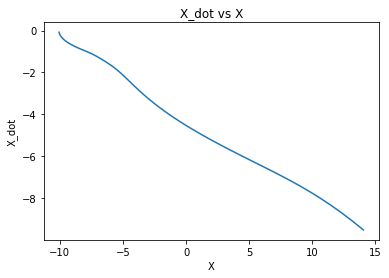

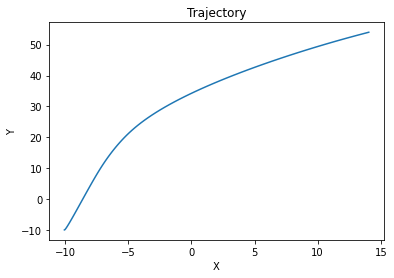

-------------------

Iteration:   65
loss: 0.008


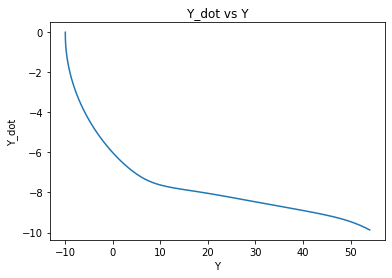

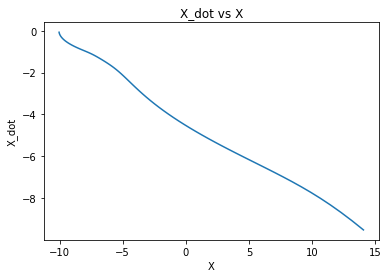

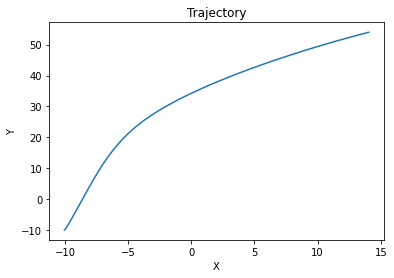

-------------------

Iteration:   66
loss: 0.006


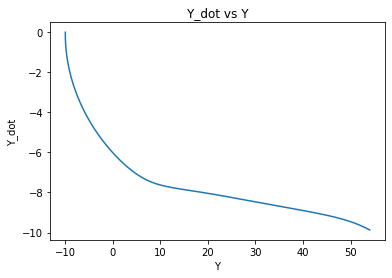

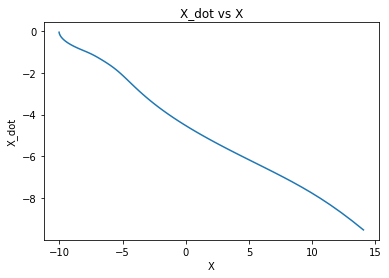

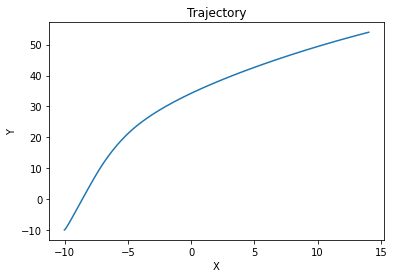

-------------------

Iteration:   67
loss: 0.005


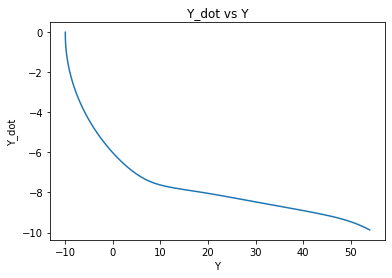

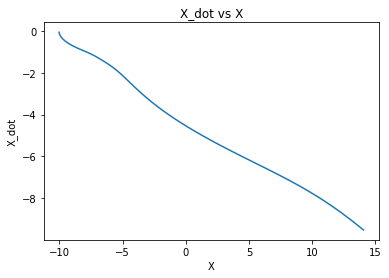

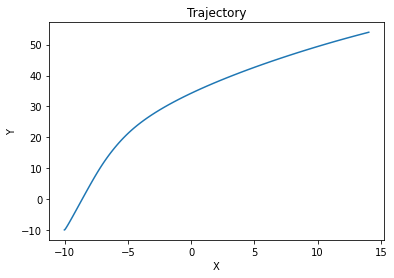

-------------------

Iteration:   68
loss: 0.004


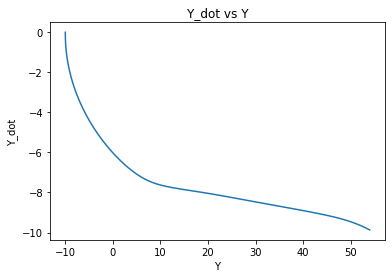

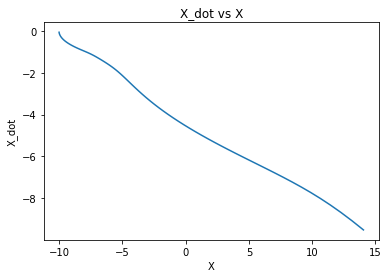

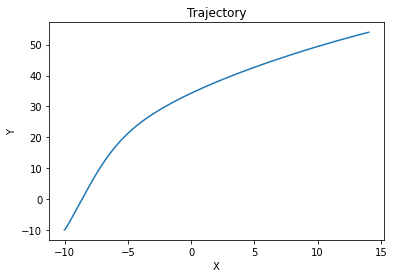

-------------------

Iteration:   69
loss: 0.004


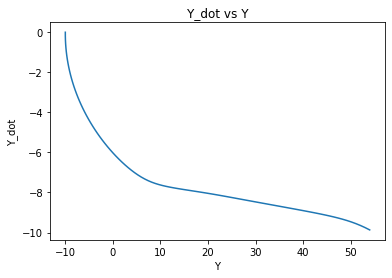

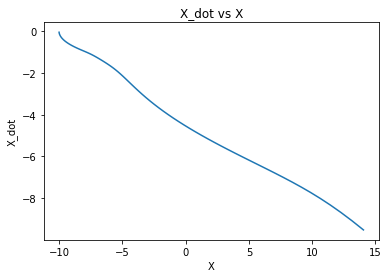

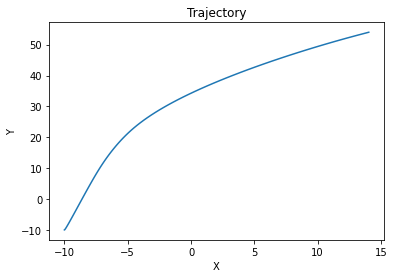

-------------------

Iteration:   70
loss: 0.003


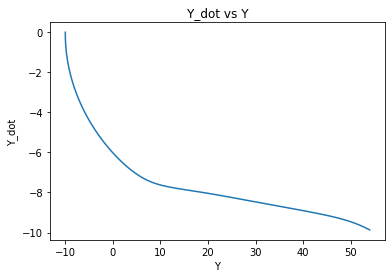

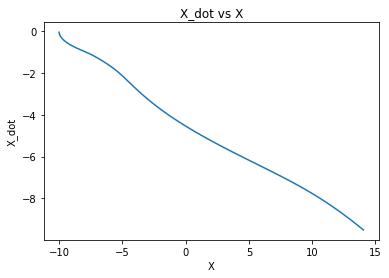

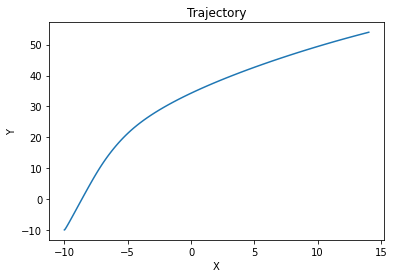

In [103]:
# Now it's time to run the code!

T = 100  # number of time steps
dim_input = 4  # state space dimensions (y, y_dot, x, x_dot)
dim_hidden = 6  # latent dimensions
dim_output = 2  # action space dimensions (x and y thrust)
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(70)  # solve the optimization problem

## 3. Analysis

1. We can see that the simulation here has been converged, the velocities are zero at the final landing point and the trajectory follows a simple curve from the initial to final point.
2. The trajectory converges at around 45 iterations only but we allow it to run until 70 to observe any changes but we find none further improvements after about 50 iterations.
3. Loss decreases rapidly from 21000 to 0 in about 50 iterations only and stays converged after that. The rate of decrease of loss is about 1/2 every iteration.
4. The loss is close to 0(less than 1) at about 30 iterations and then refines to 0 in about 20 more iterations.
5. We can probably tell from the trajectory that this is not the most optimal trajectory as we should also take into account rotational angle of the rocket, but as it will not change the trajectory we can assume the rotational angle of the rocket has also converged to 0 at the final point.
6. A more realistic and safe landing prfile would be where the rocket first reaches above the landing point and then slowl lowers itself over the landing point, technically this means that first we converge the x distance and velocity and then y distance and velocity.